# ResNet50 Cifar100 Based Image Classification Retraining

In [21]:
# Import required dependecies:
import os
import torch
import platform
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models import resnet50
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [22]:
# Define hyperparameters:
num_epochs = 40
LEARNING_RATE = 0.0005

In [23]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Display GPU details if available
if device.type == "cuda":
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    
# Display CPU details
print(f"CPU: {platform.processor()}")
print(f"System: {platform.system()} {platform.release()}")

Using device: cuda
GPU Name: Orin
CUDA Version: 12.6
GPU Memory: 7.99 GB
CPU: aarch64
System: Linux 5.15.148-tegra


In [24]:
# Define transformations
transform = transforms.Compose([
    #transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [25]:
# Load CIFAR-100 dataset
train_dataset = datasets.CIFAR100(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR100(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [26]:
# Load pre-trained ResNet50 model
model = resnet50(pretrained=True)

In [27]:
# Modify the final layer for CIFAR-100 (100 classes)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 100)

In [28]:
# Move model to device
model = model.to(device)

In [29]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [30]:
# Training loop
train_acc, val_acc = [], []

for epoch in range(num_epochs):
    model.train()
    correct, total, epoch_loss = 0, 0, 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc.append(correct / total * 100)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}, Train Acc: {train_acc[-1]:.2f}%")

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_acc.append(correct / total * 100)
    print(f"Validation Acc: {val_acc[-1]:.2f}%")

Epoch [1/40], Loss: 3.3249, Train Acc: 20.76%
Validation Acc: 32.43%
Epoch [2/40], Loss: 2.7373, Train Acc: 31.39%
Validation Acc: 34.59%
Epoch [3/40], Loss: 2.4608, Train Acc: 36.61%
Validation Acc: 39.64%
Epoch [4/40], Loss: 2.2132, Train Acc: 41.56%
Validation Acc: 45.86%
Epoch [5/40], Loss: 1.9403, Train Acc: 47.13%
Validation Acc: 45.50%
Epoch [6/40], Loss: 1.7855, Train Acc: 50.87%
Validation Acc: 48.67%
Epoch [7/40], Loss: 1.6658, Train Acc: 53.60%
Validation Acc: 50.93%
Epoch [8/40], Loss: 1.5520, Train Acc: 56.35%
Validation Acc: 51.50%
Epoch [9/40], Loss: 1.4302, Train Acc: 59.12%
Validation Acc: 51.59%
Epoch [10/40], Loss: 1.3040, Train Acc: 62.45%
Validation Acc: 53.74%
Epoch [11/40], Loss: 1.2083, Train Acc: 64.76%
Validation Acc: 53.30%
Epoch [12/40], Loss: 1.1120, Train Acc: 67.31%
Validation Acc: 52.87%
Epoch [13/40], Loss: 1.0164, Train Acc: 69.74%
Validation Acc: 54.56%
Epoch [14/40], Loss: 0.9476, Train Acc: 71.39%
Validation Acc: 54.47%
Epoch [15/40], Loss: 0.8526, 

In [34]:
# Define base model path
base_path = "/home/aman-nvidia/My_files/cv_projects/image_classification_webGUI/resnet50_cifar100"
file_extension = ".pth"

# Function to create filename with num_epochs AND counter (for saving)
def get_model_path_save(base_path, file_extension, num_epochs):  # Renamed to clarify
    epoch_path = f"{base_path}_{num_epochs}"

    counter = 1
    model_path = f"{epoch_path}{file_extension}"

    while os.path.exists(model_path):
        model_path = f"{epoch_path}_{counter}{file_extension}"
        counter += 1

    return model_path

# Save the model
model_path = get_model_path_save(base_path, file_extension, num_epochs)
torch.save(model.state_dict(), model_path)
print(f"Model saved successfully as: {model_path}")

Model saved successfully as: /home/aman-nvidia/My_files/cv_projects/image_classification_webGUI/resnet50_cifar100_40.pth


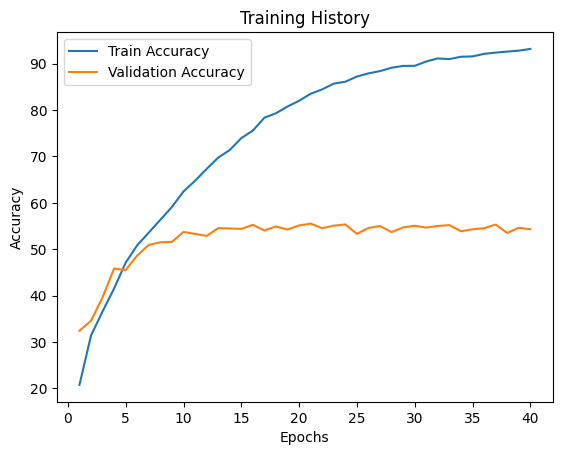

In [35]:
# Plot training history
plt.plot(range(1, num_epochs + 1), train_acc, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training History")
plt.show()